# Imports

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import warnings
warnings.filterwarnings("ignore")

# Reading the data

In [15]:
# Reading the data
tr_tr = pd.read_csv('./train_transaction.csv')
te_tr = pd.read_csv('./test_transaction.csv')
tr_id = pd.read_csv('./train_identity.csv')
te_id = pd.read_csv('./test_identity.csv')


COLS_TO_SHOW = int(tr_tr.shape[1] * 0.5)

# EDA Functions and Navigation

In [16]:
def h(content): # Function for displaying content in HTML/Markdown format
    display(HTML(content)) # display content in HTML/Markdown format


def timehist1(col): # Function for displaying line plot for a (transaction datetime/given column) - Time Histogram
    N = 8000 if col in ['TransactionAmt'] else 9999999999999999 # Clip transaction amount for better view
    # Line plot for a (transaction datetime/given column) in train_transaction where isFraud is False 
    tr_tr[tr_tr['isFraud'] == 0].set_index('TransactionDT')[col].clip(0, N).plot(style='.', title='Hist ' + col, figsize=(15, 3))
    # Line plot for a (transaction datetime/given column) in train_transaction where isFraud is True
    tr_tr[tr_tr['isFraud'] == 1].set_index('TransactionDT')[col].clip(0, N).plot(style='.', title='Hist ' + col, figsize=(15, 3))
    # Line plot for a (transaction datetime/given column) in test_transaction
    te_tr.set_index('TransactionDT')[col].clip(0, N).plot(style='.', title=col + ' values over time (blue=no-fraud, orange=fraud, green=test)', figsize=(15, 3))
    plt.show() # Show plot
    

def _desc(data, col, label): # Column description in a given dataset
    d0 = data.describe().reset_index() # Basic description (mean, std, min, max etc...) for a column
    d0.columns = [col, label]
    # Append column's unique values, number of NaNs and NaNs share and return it
    return d0.append({col:'unique values', label:data.unique().shape[0]}, ignore_index=True) \
             .append({col:'NaNs', label:data.isnull().sum()}, ignore_index=True) \
             .append({col:'NaNs share', label:np.round(data.isnull().sum() / data.shape[0], 4)}, ignore_index=True) \


def desc1(col): # Function for column description
    d0 = _desc(tr_tr[col], col, 'Train') # Description for column in Train dataset
    d1 = _desc(tr_tr.loc[tr_tr['isFraud'] == 1, col], col, 'Train fraud') # Description for column in Train dataset where Fraud is True
    d2 = _desc(tr_tr.loc[tr_tr['isFraud'] == 0, col], col, 'Train Not fraud') # Description for column in Train dataset where Fraud is False
    d3 = _desc(te_tr[col], col, 'Test') # Description for column in Test dataset
    n_public = int(te_tr.shape[0] * 0.2) # 20% of test data
    d4 = _desc(te_tr.loc[:n_public, col], col, 'Test public') # Description for column in Test public (20%)
    d5 = _desc(te_tr.loc[n_public:, col], col, 'Test private') # Description for column in Test private (80%)
    dd = d0.merge(d1).merge(d2).merge(d3).merge(d4).merge(d5) # Merge all descriptive Datasets together
    display(dd) # Display the resulting descriptive Dataset

    if col not in ['TransactionID']:
        h('<b>Most popular values (NaN = -999):</b>')
        N = 10
        # Size, mean and sum results for isFraud column grouped by a given column in Train dataset
        d0 = tr_tr[['isFraud',col]].fillna(-999).groupby(col)['isFraud'].agg(['size','mean','sum']).reset_index().sort_values('size', ascending=False).reset_index(drop=True)
        # Count results for TransactionID column grouped by a given column in Test dataset
        d1 = te_tr[['TransactionID',col]].fillna(-999).groupby(col)['TransactionID'].count().reset_index()
        dd = d0.merge(d1, how='left', on=col).head(N) # Merge d0 and d1 results together
        dd = dd.rename({'size':'Count in train (desc)','mean':'Mean target','sum':'Sum target','TransactionID':'Count in test'}, axis=1) # Renaming dataframe columns
        display(dd) # Display the resulting descriptive Dataset

        h('<b>Biggest fraud sum values in train (NaN = -999):</b>')
        # Biggest values for d0 and d1 combined
        dd = d0.sort_values('sum', ascending=False).reset_index(drop=True).head(N).merge(d1, how='left', on=col)
        dd = dd.rename({'size':'Count in train','mean':'Mean target','sum':'Sum target (desc)','TransactionID':'Count in test'}, axis=1) # Renaming dataframe columns
        display(dd) # Display the resulting descriptive Dataset


def hist1(col): # Function for histogram for a given column in Train and Test datasets
    plt.figure(figsize=(15, 3)) # Size of a plot
    plt.subplot(121) # Number of rows, number of columns and index for a subplot
    plt.hist(tr_tr[col], bins=70); # Histogram for a given column
    plt.title('Train histogram: ' + col); # Title for a histogram
    plt.subplot(122) # Number of rows, number of columns and index for a subplot
    plt.hist(te_tr[col], bins=70); # Histogram for a given column
    plt.title('Test histogram: ' + col); # Title for a histogram
    plt.show() # Show histograms


def corr1(col): # Function for the most correlated values for the given column - Correlation
    N = None #10000
    num_vars = [f for f in tr_tr.columns if tr_tr[f].dtype != 'object'] # List of all numeric columns
    trx = tr_tr.head(N) if N is not None else tr_tr.copy() # Temporary dataframe for the correlation results
    # The most correlated columns with the given column (Only numeric columns)
    corrs = trx[num_vars].corrwith(trx[col]).reset_index().sort_values(0, ascending=False).reset_index(drop=True).rename({'index':'Column',0:'Correlation with ' + col}, axis=1)
    h('<b>Most correlated values with ' + col + ':</b>')
    trx = pd.concat([corrs.head(6), corrs.dropna().tail(5)]) # Final correlation results to dataframe
    def linkx(val):
        return '<a href="#c_{}">{}</a>'.format(val, val) if val in included_cols else val
    trx['Column'] = trx['Column'].apply(linkx)
    h(trx.to_html(escape=False))


def numeric(col): # EDA for numeric columns
    timehist1(col) # Time histogram
    hist1(col) # Histogram of
    desc1(col) # Description
    corr1(col) # Correlation


def categorical(col): # EDA for categorical columns
    desc1(col) # Description


def proc(col): # Function for running eda
    if col not in ['isFraud','TransactionDT']:
        h('<h3 id="c_' + col + '">' + col + '</h3>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')
        categorical(col) if tr_tr[col].dtype == 'object' else numeric(col) # Make EDA for a column

# Navigation
included_cols = list(tr_tr.columns.values[:COLS_TO_SHOW])
split_on = ['TransactionID','card1','addr1','C1','D1','M1','V1']
h('<b>Links to column info:</b> ' + ', '.join([('<li>' if col in split_on else '') + '<a href="#c_' + col + '">' + col + '</a>' for col in included_cols]))
# Shapes of datasets
h('Train transactions shape: <b>' + str(tr_tr.shape) + '</b>, identity <b>' + str(tr_id.shape) + '</b>' + 
  '<br>Test transactions shape: <b>' + str(te_tr.shape) + '</b>, identity <b>' + str(te_id.shape) + '</b>')
# train_transaction preview
h('Train transactions preview:')
display(tr_tr.head(10))

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# TransactionDT EDA

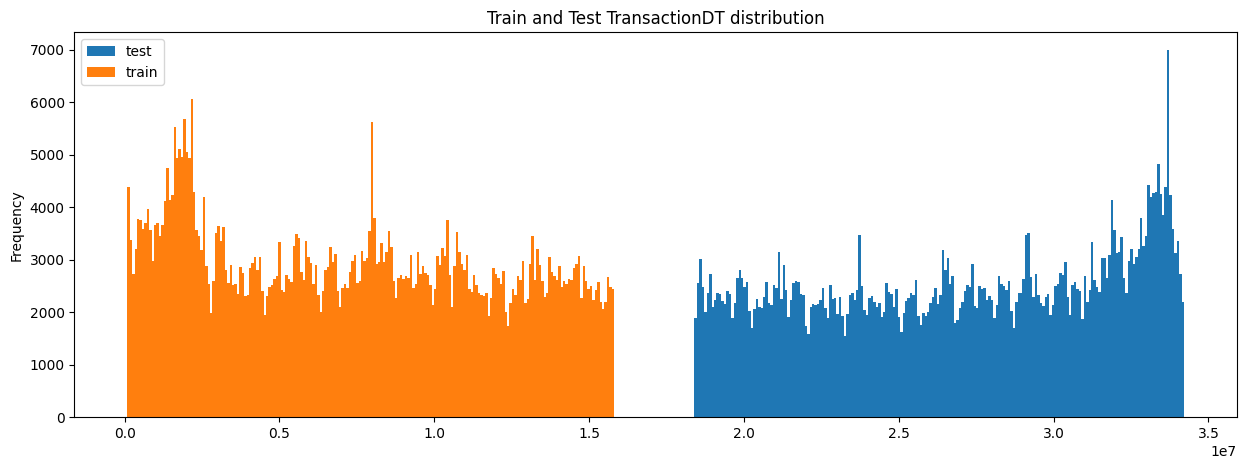

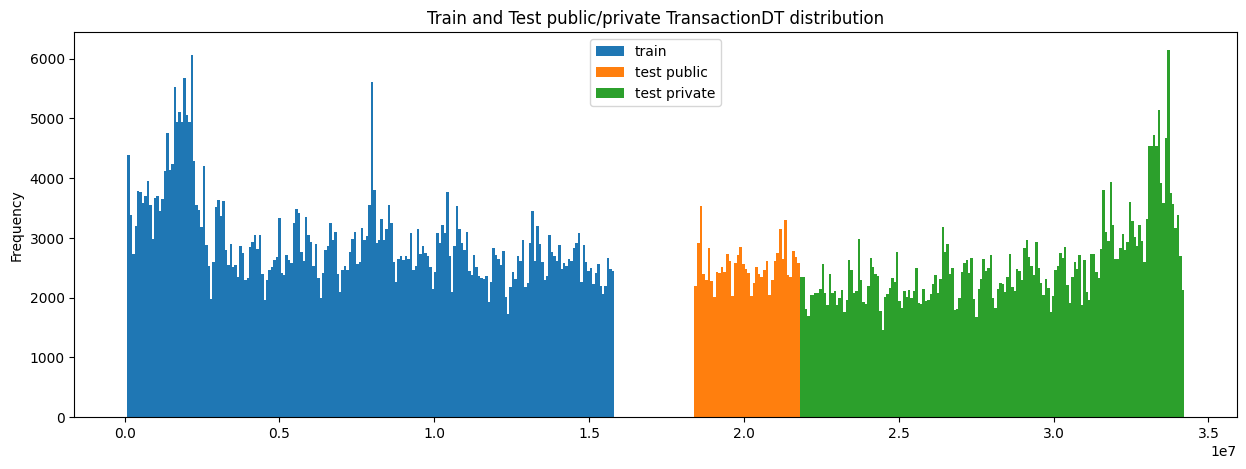

,Column,Correlation with TransactionDT
0,TransactionDT,1.000000
1,TransactionID,0.998280
2,V330,0.258603
3,V326,0.257295
4,V329,0.252599
5,V327,0.248494
375,V145,-0.252731
376,V160,-0.265566
377,V159,-0.279138
378,V151,-0.280576


In [17]:
# TransactionDT EDA
COL = 'TransactionDT'
h('<h2 id="c_' + COL + '">' + COL + '</h2>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')

# Train and Test TransactionDT distribution
te_tr['TransactionDT'].plot(kind='hist', figsize=(15, 5), label='test', bins=200, title='Train and Test TransactionDT distribution')
tr_tr['TransactionDT'].plot(kind='hist', label='train', bins=200)
plt.legend()
plt.show()

# Train and Test public/private TransactionDT distribution
tr_tr['TransactionDT'].plot(kind='hist', figsize=(15, 5), label='train', bins=200, title='Train and Test public/private TransactionDT distribution')
n_public = int(te_tr.shape[0] * 0.2)
te_tr.loc[:n_public, 'TransactionDT'].plot(kind='hist', label='test public', bins=40)
te_tr.loc[n_public:, 'TransactionDT'].plot(kind='hist', label='test private', bins=160)
plt.legend()
plt.show()

corr1(COL) # Most correlated columns with TransactionDT

# isFraud EDA

In [18]:
# isFraud EDA
COL = 'isFraud'
h('<h2 id="c_' + COL + '">' + COL + '</h2>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')
h('This is target column.')
# True and False counts in isFraud column
trx = tr_tr['isFraud'].value_counts().reset_index().rename({'index':'Value','isFraud':'Count'}, axis=1)
# Percentage of True and False in isFraud column
trx['Share'] = np.round(trx['Count'] / trx['Count'].sum(), 6)
display(trx) # Display the resulting stats
corr1(COL) # Most correlated columns with isFraud column

,Value,Count,Share
0,0,569877,0.96501
1,1,20663,0.03499


,Column,Correlation with isFraud
0,isFraud,1.000000
1,V257,0.383060
2,V246,0.366878
3,V244,0.364129
4,V242,0.360590
5,V201,0.328005
375,V90,-0.110168
376,V49,-0.110920
377,V48,-0.115786
378,D7,-0.127199


# EDA for other columns

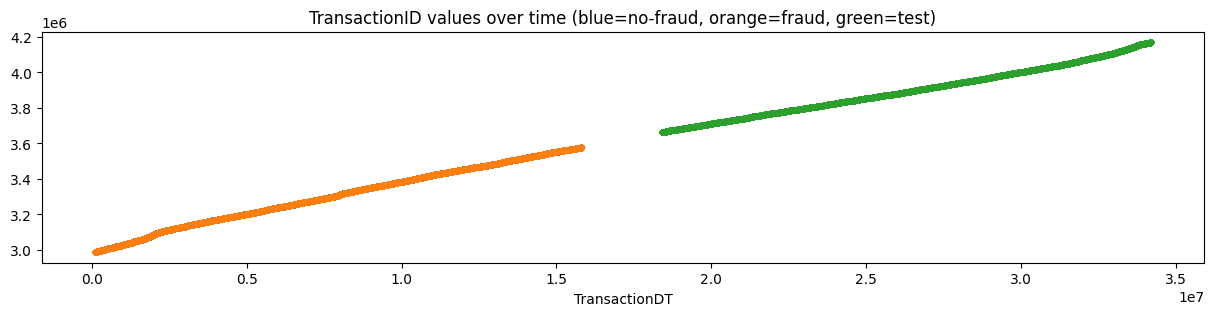

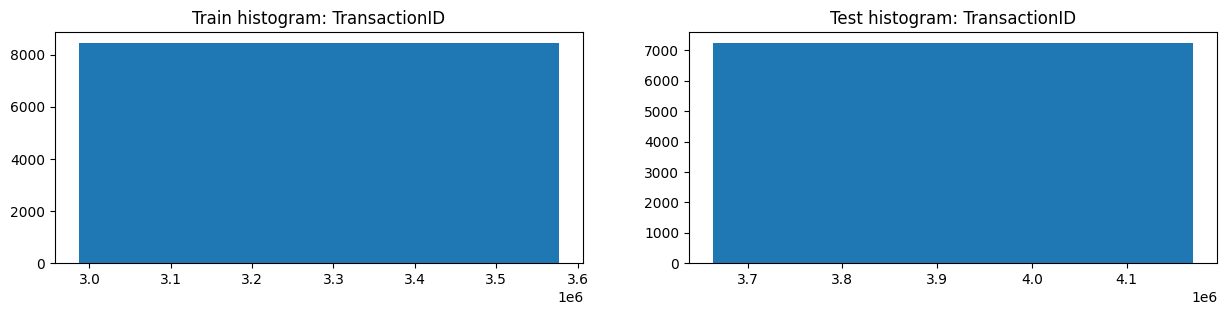

,TransactionID,Train,Train fraud,Train Not fraud,Test,Test public,Test private
0,count,5.905400e+05,2.066300e+04,5.698770e+05,5.066910e+05,1.013390e+05,4.053530e+05
1,mean,3.282270e+06,3.294952e+06,3.281810e+06,3.916894e+06,3.714218e+06,3.967563e+06
2,std,1.704744e+05,1.620403e+05,1.707548e+05,1.462692e+05,2.925419e+04,1.170155e+05
3,min,2.987000e+06,2.987203e+06,2.987000e+06,3.663549e+06,3.663549e+06,3.764887e+06
4,25%,3.134635e+06,3.167366e+06,3.133317e+06,3.790222e+06,3.688884e+06,3.866225e+06
5,50%,3.282270e+06,3.291934e+06,3.281808e+06,3.916894e+06,3.714218e+06,3.967563e+06
6,75%,3.429904e+06,3.428646e+06,3.429974e+06,4.043566e+06,3.739552e+06,4.068901e+06
7,max,3.577539e+06,3.577526e+06,3.577539e+06,4.170239e+06,3.764887e+06,4.170239e+06
8,unique values,5.905400e+05,2.066300e+04,5.698770e+05,5.066910e+05,1.013390e+05,4.053530e+05
9,NaNs,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


,Column,Correlation with TransactionID
0,TransactionID,1.000000
1,TransactionDT,0.998280
2,V326,0.251746
3,V330,0.250831
4,V329,0.244867
5,V327,0.242576
375,V145,-0.273548
376,V160,-0.282572
377,V159,-0.302742
378,V151,-0.303988


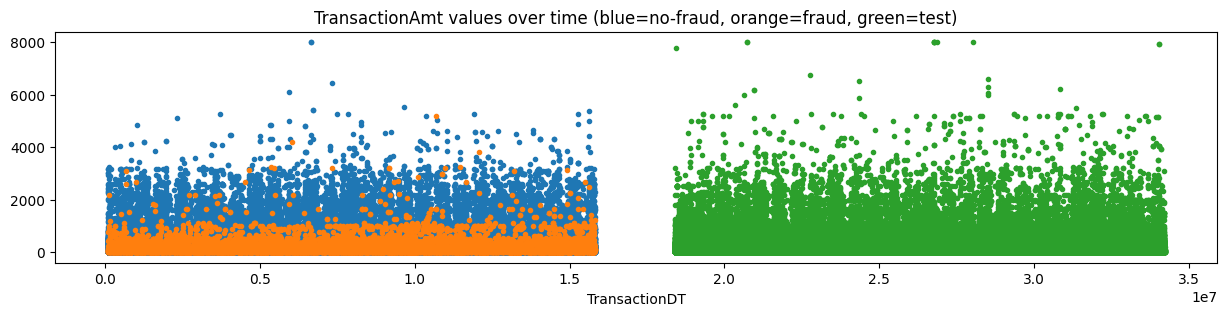

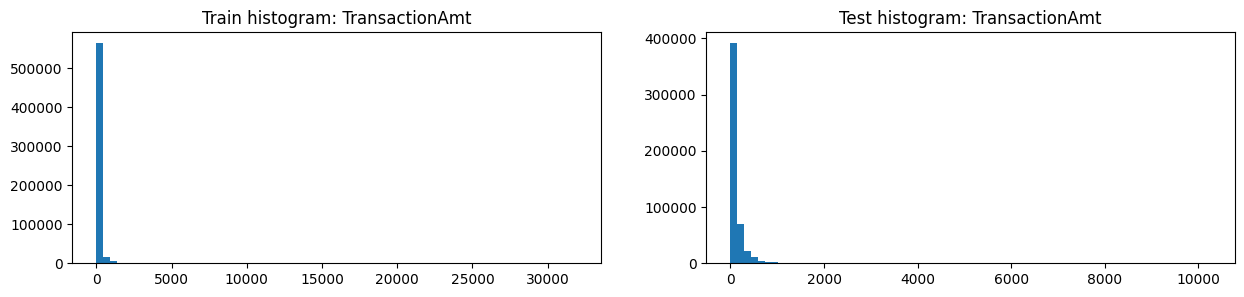

,TransactionAmt,Train,Train fraud,Train Not fraud,Test,Test public,Test private
0,count,590540.000000,20663.000000,569877.000000,506691.000000,101339.000000,405353.000000
1,mean,135.027176,149.244779,134.511665,134.725568,141.732271,132.973690
2,std,239.162522,232.212163,239.395078,245.779822,257.473804,242.736757
3,min,0.251000,0.292000,0.251000,0.018000,0.018000,0.140000
4,25%,43.321000,35.044000,43.970000,40.000000,45.950000,39.000000
5,50%,68.769000,75.000000,68.500000,67.950000,72.950000,67.950000
6,75%,125.000000,161.000000,120.000000,125.000000,134.950000,120.950000
7,max,31937.391000,5191.000000,31937.391000,10270.000000,9154.460000,10270.000000
8,unique values,20902.000000,2515.000000,20560.000000,14119.000000,5144.000000,12117.000000
9,NaNs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,TransactionAmt,Count in train (desc),Mean target,Sum target,Count in test
0,59.00,30582,0.021124,646,27365.0
1,117.00,28933,0.024851,719,25798.0
2,107.95,23954,0.009226,221,20243.0
3,57.95,23600,0.003814,90,20063.0
4,100.00,20362,0.025685,523,17565.0
5,50.00,17009,0.020754,353,14469.0
6,49.00,15990,0.029331,469,14231.0
7,226.00,11704,0.033322,390,11084.0
8,39.00,11095,0.021812,242,9926.0
9,29.00,10683,0.018815,201,9019.0


,TransactionAmt,Count in train,Mean target,Sum target (desc),Count in test
0,117.0,28933,0.024851,719,25798
1,59.0,30582,0.021124,646,27365
2,150.0,8356,0.067137,561,7426
3,100.0,20362,0.025685,523,17565
4,49.0,15990,0.029331,469,14231
5,200.0,6590,0.064188,423,6115
6,226.0,11704,0.033322,390,11084
7,300.0,2438,0.145611,355,2104
8,50.0,17009,0.020754,353,14469
9,171.0,7682,0.035407,272,7233


,Column,Correlation with TransactionAmt
0,TransactionAmt,1.000000
1,V139,0.222308
2,V140,0.207470
3,V208,0.198601
4,V161,0.197351
5,V163,0.191320
375,V15,-0.139413
376,V94,-0.141014
377,V52,-0.142297
378,V50,-0.144958


,ProductCD,Train,Train fraud,Train Not fraud,Test,Test public,Test private
0,count,590540,20663,569877,506691,101339,405353
1,unique,5,5,5,5,5,5
2,top,W,W,W,W,W,W
3,freq,439670,8969,430701,360987,82563,278425
4,unique values,5,5,5,5,5,5
5,NaNs,0,0,0,0,0,0
6,NaNs share,0.0,0.0,0.0,0.0,0.0,0.0


,ProductCD,Count in train (desc),Mean target,Sum target,Count in test
0,W,439670,0.020399,8969,360987
1,C,68519,0.116873,8008,69266
2,R,37699,0.037826,1426,35647
3,H,33024,0.047662,1574,29373
4,S,11628,0.058996,686,11418


,ProductCD,Count in train,Mean target,Sum target (desc),Count in test
0,W,439670,0.020399,8969,360987
1,C,68519,0.116873,8008,69266
2,H,33024,0.047662,1574,29373
3,R,37699,0.037826,1426,35647
4,S,11628,0.058996,686,11418


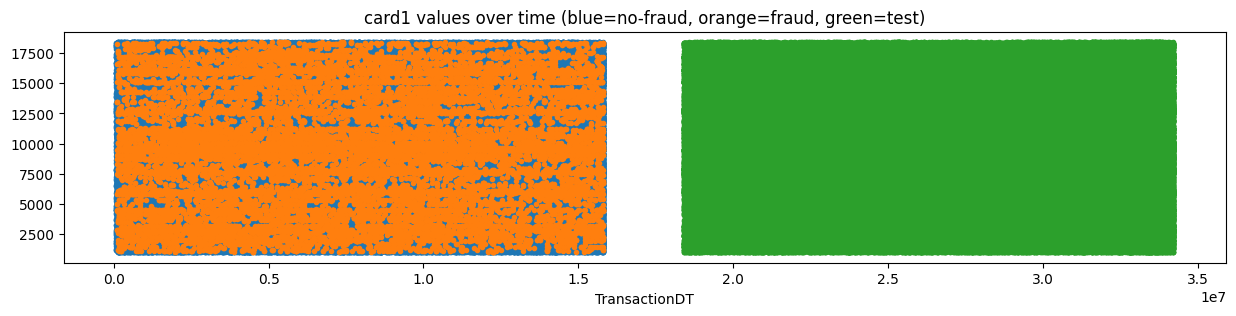

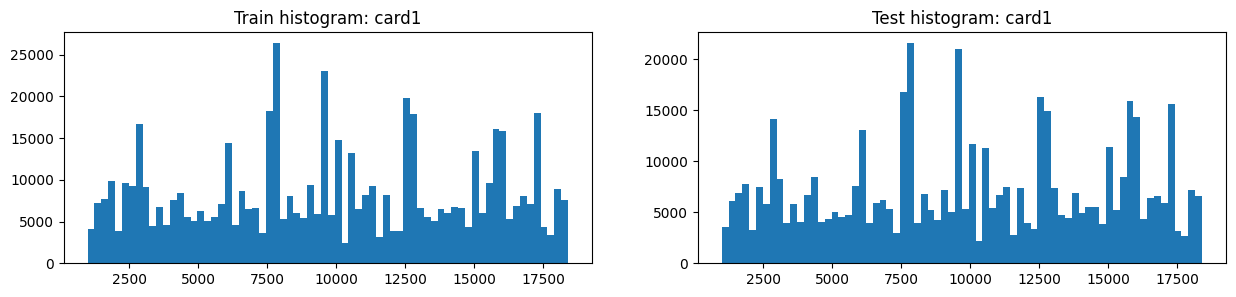

,card1,Train,Train fraud,Train Not fraud,Test,Test public,Test private
0,count,590540.000000,20663.000000,569877.000000,506691.000000,101339.000000,405353.000000
1,mean,9898.734658,9547.654164,9911.464381,9957.222175,9907.330406,9969.701591
2,std,4901.170153,4762.051380,4905.672370,4884.960969,4854.917514,4892.365179
3,min,1000.000000,1015.000000,1000.000000,1001.000000,1006.000000,1001.000000
4,25%,6019.000000,5732.500000,6019.000000,6019.000000,6053.000000,6019.000000
5,50%,9678.000000,9633.000000,9711.000000,9803.000000,9653.000000,9803.000000
6,75%,14184.000000,13623.000000,14229.000000,14276.000000,14052.000000,14290.000000
7,max,18396.000000,18375.000000,18396.000000,18397.000000,18396.000000,18397.000000
8,unique values,13553.000000,1740.000000,13350.000000,13244.000000,6935.000000,12300.000000
9,NaNs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,card1,Count in train (desc),Mean target,Sum target,Count in test
0,7919,14932,0.007501,112,13083.0
1,9500,14162,0.037283,528,12081.0
2,15885,10361,0.042853,444,12330.0
3,17188,10344,0.026875,278,9262.0
4,15066,7945,0.039396,313,6661.0
5,12695,7091,0.028346,201,5641.0
6,12544,6773,0.021556,146,5921.0
7,6019,6771,0.043420,294,6497.0
8,2803,6141,0.011887,73,4902.0
9,7585,5334,0.049306,263,4763.0


,card1,Count in train,Mean target,Sum target (desc),Count in test
0,9633,4158,0.178451,742,4751
1,9500,14162,0.037283,528,12081
2,15885,10361,0.042853,444,12330
3,9026,2076,0.191233,397,894
4,15063,2522,0.126487,319,2060
5,5812,2818,0.111427,314,3879
6,2616,4410,0.071202,314,1786
7,15066,7945,0.039396,313,6661
8,9917,919,0.332971,306,920
9,6019,6771,0.043420,294,6497


,Column,Correlation with card1
0,card1,1.000000
1,V330,0.146483
2,V329,0.142539
3,V324,0.138616
4,V333,0.136557
5,V328,0.134419
375,V149,-0.023889
376,V156,-0.024232
377,D13,-0.028603
378,D8,-0.040851


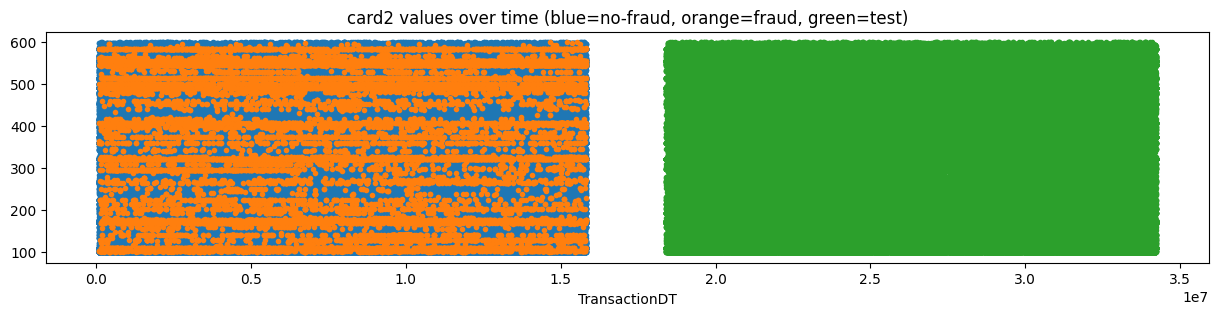

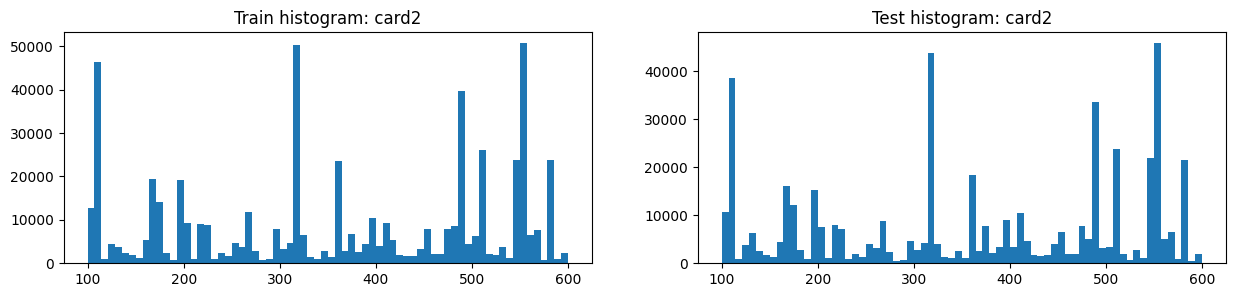

,card2,Train,Train fraud,Train Not fraud,Test,Test public,Test private
0,count,581607.000000,20240.000000,561367.000000,498037.000000,99008.000000,399030.000000
1,mean,362.555488,365.370850,362.453981,363.735379,358.809076,364.957595
2,std,157.793246,159.623511,157.726065,158.688653,157.772855,158.891431
3,min,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
4,25%,214.000000,204.000000,215.000000,207.000000,204.000000,214.000000
5,50%,361.000000,375.000000,361.000000,369.000000,360.000000,375.000000
6,75%,512.000000,514.000000,512.000000,512.000000,512.000000,514.000000
7,max,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
8,unique values,501.000000,328.000000,501.000000,498.000000,497.000000,497.000000
9,NaNs,8933.000000,423.000000,8510.000000,8654.000000,2331.000000,6323.000000


,card2,Count in train (desc),Mean target,Sum target,Count in test
0,321.0,48935,0.028528,1396,42796.0
1,111.0,45191,0.021641,978,37346.0
2,555.0,41995,0.022836,959,38409.0
3,490.0,38145,0.024014,916,32351.0
4,583.0,21803,0.041233,899,19700.0
5,170.0,18214,0.031295,570,15197.0
6,194.0,16938,0.007675,130,14573.0
7,545.0,16355,0.086824,1420,15539.0
8,360.0,15190,0.010402,158,11342.0
9,514.0,14541,0.046214,672,12684.0


,card2,Count in train,Mean target,Sum target (desc),Count in test
0,545.0,16355,0.086824,1420,15539
1,321.0,48935,0.028528,1396,42796
2,111.0,45191,0.021641,978,37346
3,555.0,41995,0.022836,959,38409
4,490.0,38145,0.024014,916,32351
5,500.0,5045,0.180575,911,2430
6,583.0,21803,0.041233,899,19700
7,408.0,8012,0.083999,673,9148
8,514.0,14541,0.046214,672,12684
9,130.0,2746,0.239257,657,5395


,Column,Correlation with card2
0,card2,1.000000
1,V302,0.097911
2,V304,0.096949
3,V303,0.092447
4,V50,0.084508
5,V71,0.081179
375,V36,-0.042237
376,V13,-0.043501
377,V12,-0.043553
378,V53,-0.043736


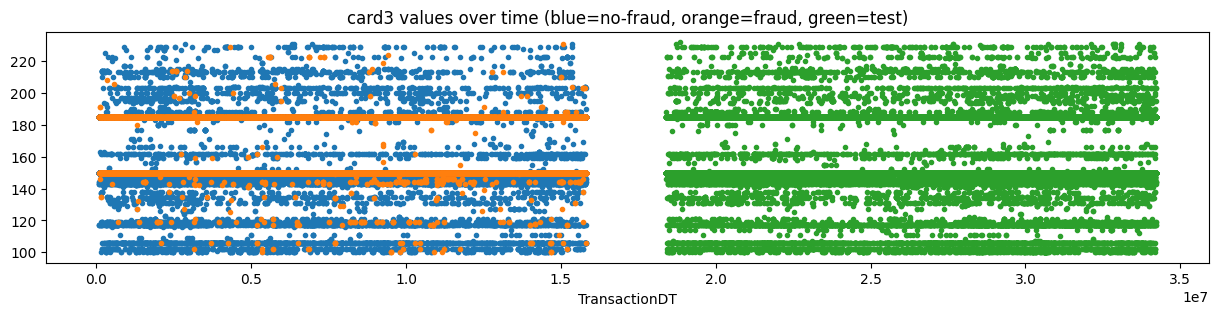

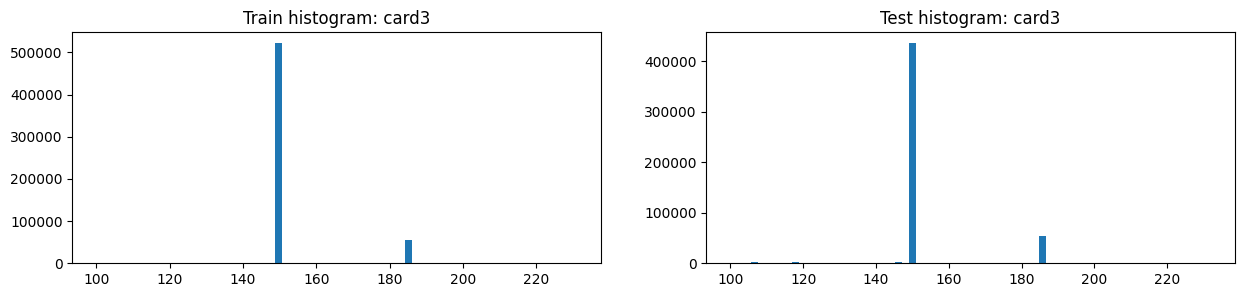

,card3,Train,Train fraud,Train Not fraud,Test,Test public,Test private
0,count,588975.000000,20624.000000,568351.000000,503689.000000,100033.000000,403657.000000
1,mean,153.194925,162.368648,152.862034,153.543409,152.127938,153.894177
2,std,11.336444,17.495775,10.904432,12.443013,10.591923,12.836503
3,min,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
4,25%,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
5,50%,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
6,75%,150.000000,185.000000,150.000000,150.000000,150.000000,150.000000
7,max,231.000000,231.000000,231.000000,232.000000,232.000000,231.000000
8,unique values,115.000000,63.000000,107.000000,116.000000,75.000000,111.000000
9,NaNs,1565.000000,39.000000,1526.000000,3002.000000,1306.000000,1696.000000


,card3,Count in train (desc),Mean target,Sum target,Count in test
0,150.0,521287,0.024568,12807,435558.0
1,185.0,56346,0.130657,7362,53614.0
2,106.0,1571,0.015277,24,1972.0
3,-999.0,1565,0.024920,39,3002.0
4,146.0,1252,0.019968,25,1218.0
5,144.0,1252,0.089457,112,1381.0
6,117.0,962,0.018711,18,1879.0
7,143.0,899,0.031146,28,771.0
8,119.0,750,0.093333,70,341.0
9,102.0,460,0.023913,11,738.0


,card3,Count in train,Mean target,Sum target (desc),Count in test
0,150.0,521287,0.024568,12807,435558
1,185.0,56346,0.130657,7362,53614
2,144.0,1252,0.089457,112,1381
3,119.0,750,0.093333,70,341
4,-999.0,1565,0.024920,39,3002
5,143.0,899,0.031146,28,771
6,146.0,1252,0.019968,25,1218
7,106.0,1571,0.015277,24,1972
8,117.0,962,0.018711,18,1879
9,223.0,55,0.254545,14,126


,Column,Correlation with card3
0,card3,1.000000
1,V15,0.759508
2,V94,0.758586
3,V16,0.744826
4,V57,0.744299
5,V79,0.738073
375,V53,-0.341900
376,V35,-0.348554
377,V54,-0.351214
378,V36,-0.356215


,card4,Train,Train fraud,Train Not fraud,Test,Test public,Test private
0,count,588963,20622,568341,503605,99996,403610
1,unique,4,4,4,4,4,4
2,top,visa,visa,visa,visa,visa,visa
3,freq,384767,13373,371394,334882,66078,268805
4,unique values,5,5,5,5,5,5
5,NaNs,1577,41,1536,3086,1343,1743
6,NaNs share,0.0027,0.002,0.0027,0.0061,0.0133,0.0043


,card4,Count in train (desc),Mean target,Sum target,Count in test
0,visa,384767,0.034756,13373,334882
1,mastercard,189217,0.034331,6496,158169
2,american express,8328,0.028698,239,7681
3,discover,6651,0.077282,514,2873
4,-999,1577,0.025999,41,3086


,card4,Count in train,Mean target,Sum target (desc),Count in test
0,visa,384767,0.034756,13373,334882
1,mastercard,189217,0.034331,6496,158169
2,discover,6651,0.077282,514,2873
3,american express,8328,0.028698,239,7681
4,-999,1577,0.025999,41,3086


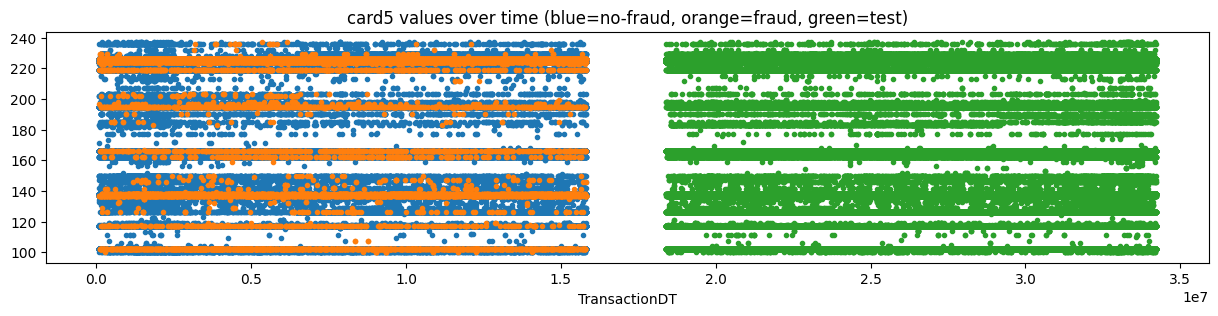

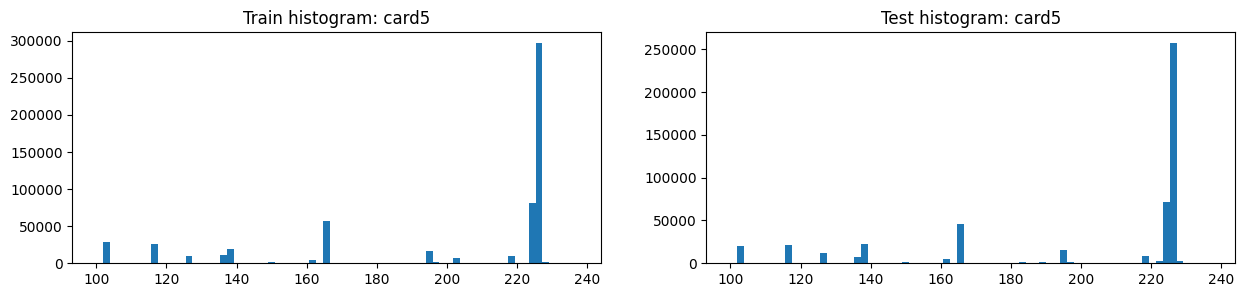

,card5,Train,Train fraud,Train Not fraud,Test,Test public,Test private
0,count,586281.000000,20453.000000,565828.000000,502144.000000,99816.000000,402329.000000
1,mean,199.278897,191.994328,199.542212,200.162975,200.406638,200.102588
2,std,41.244453,45.779886,41.046975,40.562461,40.584474,40.556792
3,min,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
4,25%,166.000000,138.000000,166.000000,166.000000,166.000000,166.000000
5,50%,226.000000,224.000000,226.000000,226.000000,226.000000,226.000000
6,75%,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000
7,max,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
8,unique values,120.000000,50.000000,119.000000,103.000000,70.000000,97.000000
9,NaNs,4259.000000,210.000000,4049.000000,4547.000000,1523.000000,3024.000000


,card5,Count in train (desc),Mean target,Sum target,Count in test
0,226.0,296546,0.029516,8753,256991.0
1,224.0,81513,0.038669,3152,71596.0
2,166.0,57140,0.011026,630,45790.0
3,102.0,29105,0.062945,1832,20386.0
4,117.0,25941,0.013646,354,21120.0
5,138.0,19737,0.085221,1682,22102.0
6,195.0,16945,0.040189,681,14951.0
7,137.0,11720,0.147184,1725,7730.0
8,126.0,10298,0.010196,105,11439.0
9,219.0,9924,0.057537,571,8402.0


,card5,Count in train,Mean target,Sum target (desc),Count in test
0,226.0,296546,0.029516,8753,256991
1,224.0,81513,0.038669,3152,71596
2,102.0,29105,0.062945,1832,20386
3,137.0,11720,0.147184,1725,7730
4,138.0,19737,0.085221,1682,22102
5,195.0,16945,0.040189,681,14951
6,166.0,57140,0.011026,630,45790
7,219.0,9924,0.057537,571,8402
8,117.0,25941,0.013646,354,21120
9,162.0,4524,0.066534,301,4512


,Column,Correlation with card5
0,card5,1.000000
1,D15,0.110301
2,D1,0.099504
3,D2,0.096315
4,D4,0.095706
5,D10,0.095575
375,V333,-0.265948
376,V324,-0.268091
377,V328,-0.270129
378,V329,-0.282868


,card6,Train,Train fraud,Train Not fraud,Test,Test public,Test private
0,count,588969,20624,568345,503684,100033,403652
1,unique,4,2,4,3,2,3
2,top,debit,debit,debit,debit,debit,debit
3,freq,439938,10674,429264,385021,78402,306620
4,unique values,5,3,5,4,3,4
5,NaNs,1571,39,1532,3007,1306,1701
6,NaNs share,0.0027,0.0019,0.0027,0.0059,0.0129,0.0042


,card6,Count in train (desc),Mean target,Sum target,Count in test
0,debit,439938,0.024263,10674,385021.0
1,credit,148986,0.066785,9950,118662.0
2,-999,1571,0.024825,39,3007.0
3,debit or credit,30,0.000000,0,NaN
4,charge card,15,0.000000,0,1.0


,card6,Count in train,Mean target,Sum target (desc),Count in test
0,debit,439938,0.024263,10674,385021.0
1,credit,148986,0.066785,9950,118662.0
2,-999,1571,0.024825,39,3007.0
3,debit or credit,30,0.000000,0,NaN
4,charge card,15,0.000000,0,1.0


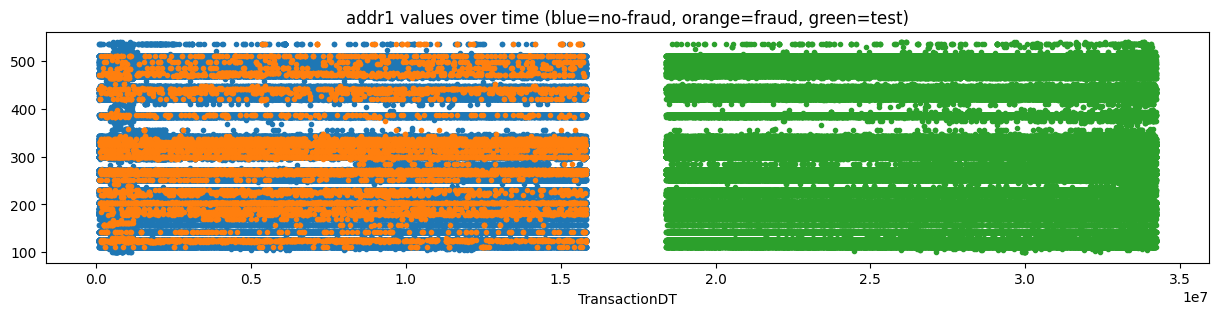

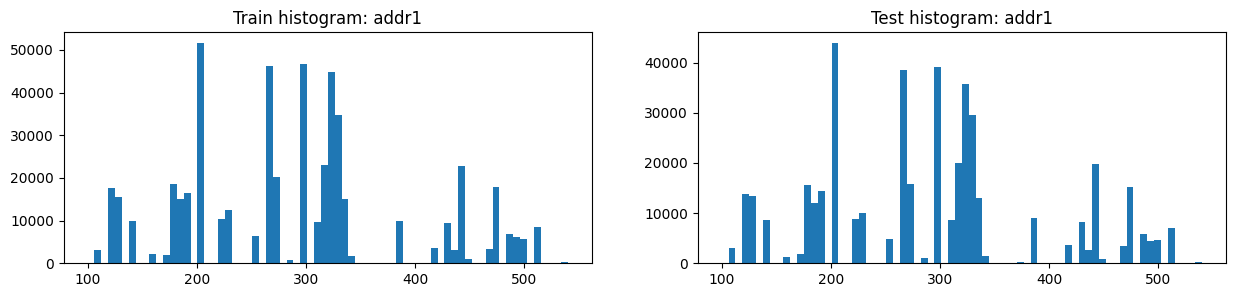

,addr1,Train,Train fraud,Train Not fraud,Test,Test public,Test private
0,count,524834.000000,12922.000000,511912.000000,441082.000000,91556.000000,349527.000000
1,mean,290.733794,294.317134,290.643341,291.846514,290.515029,292.194978
2,std,101.741072,103.584955,101.692564,102.062730,101.350107,102.245872
3,min,100.000000,110.000000,100.000000,100.000000,110.000000,100.000000
4,25%,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
5,50%,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
6,75%,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000
7,max,540.000000,536.000000,540.000000,540.000000,536.000000,540.000000
8,unique values,333.000000,87.000000,333.000000,293.000000,83.000000,289.000000
9,NaNs,65706.000000,7741.000000,57965.000000,65609.000000,9783.000000,55826.000000


,addr1,Count in train (desc),Mean target,Sum target,Count in test
0,-999.0,65706,0.117813,7741,65609.0
1,299.0,46335,0.021258,985,38710.0
2,325.0,42751,0.025426,1087,34151.0
3,204.0,42020,0.026654,1120,35049.0
4,264.0,39870,0.018259,728,32710.0
5,330.0,26287,0.031955,840,22100.0
6,315.0,23078,0.017809,411,19957.0
7,441.0,20827,0.025592,533,18063.0
8,272.0,20141,0.028598,576,15788.0
9,123.0,16105,0.024713,398,12595.0


,addr1,Count in train,Mean target,Sum target (desc),Count in test
0,-999.0,65706,0.117813,7741,65609
1,204.0,42020,0.026654,1120,35049
2,325.0,42751,0.025426,1087,34151
3,299.0,46335,0.021258,985,38710
4,330.0,26287,0.031955,840,22100
5,264.0,39870,0.018259,728,32710
6,272.0,20141,0.028598,576,15788
7,441.0,20827,0.025592,533,18063
8,337.0,15149,0.028979,439,12932
9,315.0,23078,0.017809,411,19957


KeyboardInterrupt: 

In [19]:
# EDA for other columns
for col in list(tr_tr.columns.values[:COLS_TO_SHOW]):
    proc(col) # Run EDA